In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import mne
from scipy import stats

import mni_utils as uti
from mni_plots import plot_parcellated_metric, bar_plot, mni_plot, plot_corr

### Paths and names

In [3]:
data_path = Path("F:\\iEEG_neural_dynamics\\MNIOpen")
res_dir = "Results_psd_exp"
res_path = data_path.joinpath(res_dir)
data_name = "exp"

Parcellation:

In [4]:
subjects_dir = str(mne.datasets.sample.data_path()) + "/subjects"
parc_map_name = "HCPMMP1"
annot_file = annot_file = (
    subjects_dir + "/fsaverage/label/lh." + parc_map_name + ".annot"
)
parc_labels, ctab, parc_names = nib.freesurfer.read_annot(annot_file)

## 1) Plot of parcellated brain areas

In [5]:
df_plot = {
    "W": pd.read_csv(res_path.joinpath(f"{data_name}_parc_W.csv"), index_col=0),
    "N3": pd.read_csv(res_path.joinpath(f"{data_name}_parc_N3.csv"), index_col=0),
    "R": pd.read_csv(res_path.joinpath(f"{data_name}_parc_R.csv"), index_col=0),
}

In [6]:
minmax_stages = {"W": (2, 4), "N3": (2, 3), "R": (1.5, 3.5)}
# minmax_stages = {"W": (-4.5, -2.5), "N3": (-3.5, -2), "R": (-4, -2)}
title_dict = {"W": "Wake", "N3": "NREM3", "R": "REM"}

# Loop through stages
for stage in ["W", "N3", "R"]:

    fig, ax = plot_parcellated_metric(
        df_plot[stage].to_numpy().squeeze(),
        parc_labels,
        subjects_dir,
        log_scale=False,
        minmax=minmax_stages[stage],
        title=title_dict[stage],
        cmap="inferno",
        label="Exponent [a.u.]",
    )
    # plt.show()

    fig.savefig(res_path.joinpath(f"{data_name}_parc_{stage}.png"), dpi=300)
    plt.close(fig)

Using pyvistaqt 3d backend.



### Maps of differences

In [7]:
df_plot_W_N3 = df_plot["N3"] - df_plot["W"]  # [-2/-1.8, -0.5] / (-0.5, 1.5)
df_plot_W_R = df_plot["R"] - df_plot["W"]  # [-1.5, 0.5] / (-0.5, 1)

# NREM3 figure
fig, ax = plot_parcellated_metric(
    df_plot_W_N3.to_numpy().squeeze(),
    parc_labels,
    subjects_dir,
    log_scale=False,
    minmax=(0.5, 1.8),
    zero_center=True,
    title="NREM3 - Wake",
    cmap="bwr",
    label="Exponent difference [a.u.]",
)
fig.savefig(res_path.joinpath(f"{data_name}_parc_N3-W.png"), dpi=300)
plt.close(fig)

# REM figure
fig, ax = plot_parcellated_metric(
    df_plot_W_R.to_numpy().squeeze(),
    parc_labels,
    subjects_dir,
    log_scale=False,
    minmax=(0.5, 1.5),
    zero_center=True,
    title="REM - Wake",
    cmap="bwr",
    label="Exponent difference [a.u.]",
)
fig.savefig(res_path.joinpath(f"{data_name}_parc_R-W.png"), dpi=300)
plt.close(fig)

## 2) Plot of macro-parcels

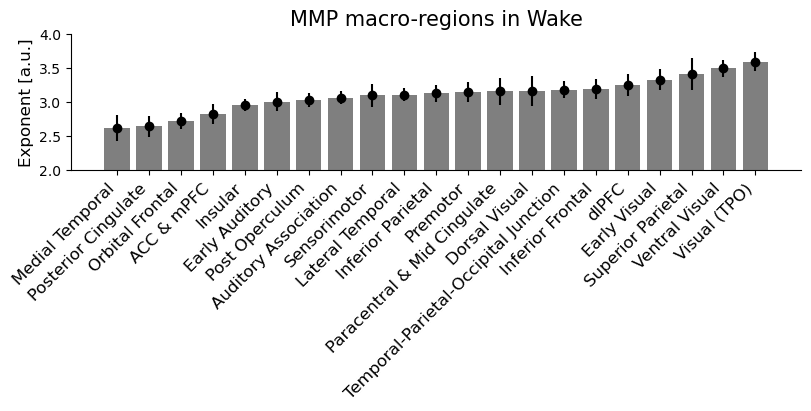

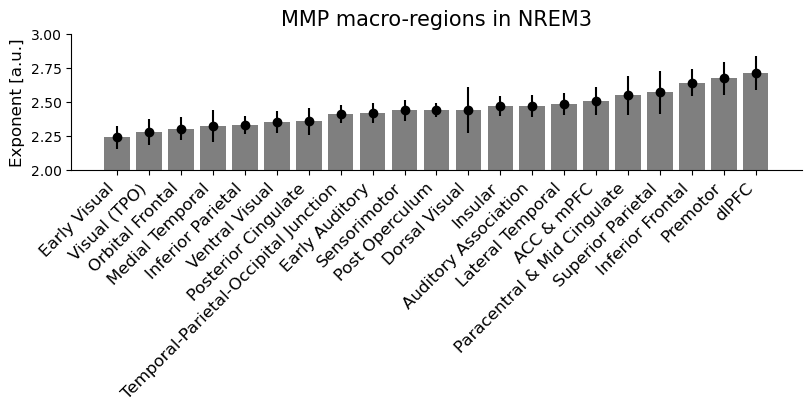

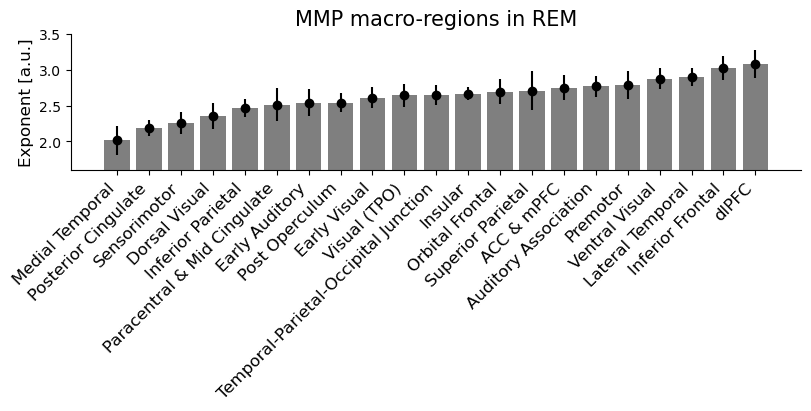

In [8]:
minmax_stages = {"W": (2, 4), "N3": (2, 3), "R": (1.6, 3.5)}
# minmax_stages = {"W": (2.5, 4.5), "N3": (2, 3.5), "R": (2, 4)}
title_dict = {"W": "Wake", "N3": "NREM3", "R": "REM"}

# Loop through stages
for stage in ["W", "N3", "R"]:
    df_plot = pd.read_csv(
        res_path.joinpath(f"{data_name}_macro_mmp_{stage}.csv"), index_col=0
    )

    fig, ax = plt.subplots(figsize=(8, 4), layout="constrained")
    ax = bar_plot(
        ax,
        df_plot,
        minmax_stages[stage],
        title="MMP macro-regions in " + title_dict[stage],
        y_label="Exponent [a.u.]",
    )
    plt.show()
    fig.savefig(
        res_path.joinpath(f"{data_name}_macro_mmp_{stage}.png"),
        dpi=300,
        bbox_inches="tight",
    )

## 3) Scatter plot of MNI macro-regions

In [9]:
title_dict = {"W": "Wake", "N3": "NREM3", "R": "REM"}

# Plot one figure per stage
df_plot_all_stages = []
for stage in ["W", "N3", "R"]:
    df_plot = pd.read_csv(
        res_path.joinpath(f"{data_name}_macro_mni_{stage}.csv"), index_col=0
    )
    df_plot.rename(columns={"stage": "cond", "exp": "Exponent [a.u.]"}, inplace=True)
    df_plot_all_stages.append(df_plot)

    df_regions = df_plot.groupby("lobe")["region"].unique()
    df_regions = df_regions.loc[
        ["Occipital", "Parietal", "Frontal", "Insula", "Temporal"]
    ]
    df_plot = df_plot.drop(columns=["lobe", "r2"])
    df_regions_len = df_regions.apply(lambda x: len(x)).cumsum()

    fig, ax = mni_plot(
        df_plot,
        df_regions_len,
        reg_order=np.concatenate(df_regions.to_list()),
        conds_order=[stage],
        title=stage,
    )
    fig.savefig(
        res_path.joinpath(f"{data_name}_macro_mni_{stage}.png"),
        dpi=300,
        bbox_inches="tight",
    )
    plt.close(fig)

# Finally, plot all regions together
df_plot_all_stages = pd.concat(df_plot_all_stages, ignore_index=True)
df_regions = df_plot_all_stages.groupby("lobe")["region"].unique()
df_regions = df_regions.loc[["Occipital", "Parietal", "Frontal", "Insula", "Temporal"]]
df_plot_all_stages.drop(columns=["lobe", "r2"], inplace=True)
df_regions_len = df_regions.apply(lambda x: len(x)).cumsum()

fig, ax = plt.subplots(figsize=(40, 5), layout="constrained")
fig, ax = mni_plot(
    df_plot_all_stages,
    df_regions_len * 2 - 1,
    reg_order=np.concatenate(df_regions.to_list()),
    conds_order=["W", "N3", "R"],
    sep=0.5,
    title="Comparison between stages",
    ax=ax,
)

fig.savefig(
    res_path.joinpath(f"{data_name}_macro_mni_all_stages.png"),
    dpi=300,
    bbox_inches="tight",
)
plt.close(fig)

## Correlation with structure

Load T1w/T2w data and the centroids coordinates of the parcellation:

In [10]:
df_struct = pd.read_csv(data_path.joinpath("df_structural_avg.csv"), index_col=0)
map_coords = pd.read_csv(data_path.joinpath("mmp_centroids_coords.csv"), index_col=0)

Generating 1000 permutations...
Generating 1000 permutations...
Generating 1000 permutations...


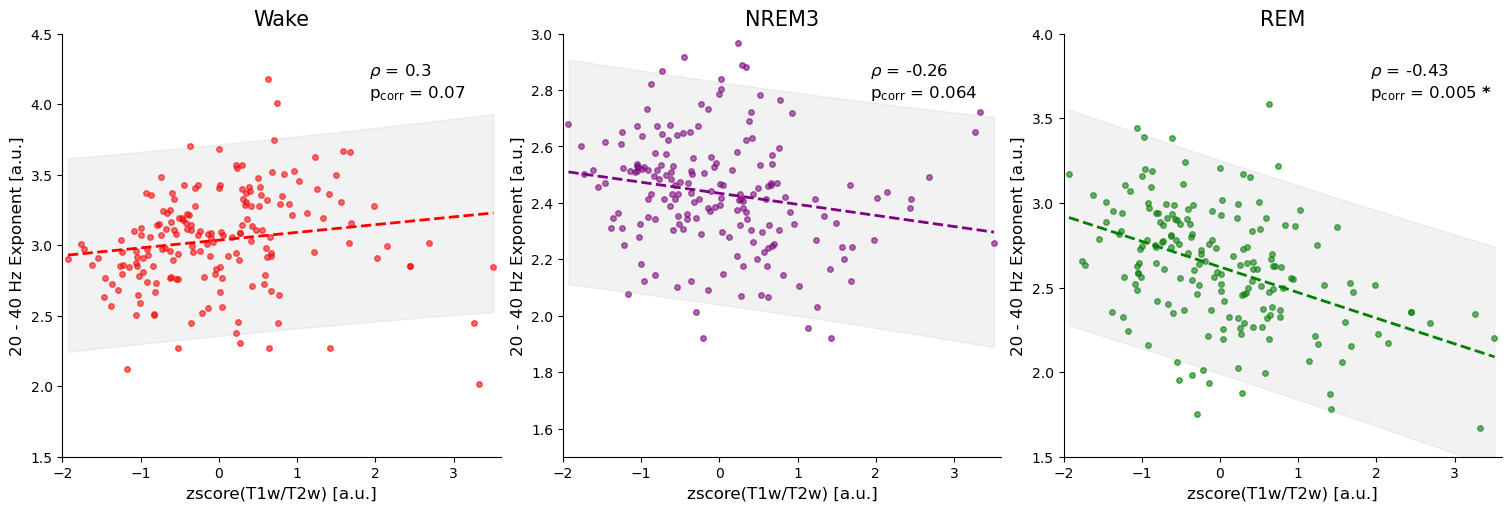

In [14]:
title_dict = {"W": "Wake", "N3": "NREM3", "R": "REM"}
color_stages = {"W": "red", "N3": "purple", "R": "green"}
xlims_stages = {"W": (-2, 3.6), "N3": (-2, 3.6), "R": (-2, 3.6)}
ylims_stages = {"W": (1.5, 4.5), "N3": (1.5, 3), "R": (1.5, 4)}

fig, axs = plt.subplots(1, 3, figsize=(15, 5), layout="constrained")

for i, stage in enumerate(["W", "N3", "R"]):
    # Import dataframe
    df_metric = pd.read_csv(
        res_path.joinpath(f"{data_name}_parc_{stage}.csv"), index_col=0
    )

    # Get data
    x = stats.zscore(df_struct["T1T2"], ddof=1).to_numpy()
    y = df_metric.loc[df_struct.index].to_numpy().squeeze()

    # Get correlation values
    rho, p_corr = uti.get_pcorr(x, y, map_coords, method="vasa", corr_type="spearman")

    axs[i] = plot_corr(
        axs[i],
        x,
        y,
        rho,
        p_corr,
        color=color_stages[stage],
        title=title_dict[stage],
        xlabel="zscore(T1w/T2w) [a.u.]",
        ylabel="20 - 40 Hz Exponent [a.u.]",
        xlims=xlims_stages[stage],
        ylims=ylims_stages[stage],
    )

fig.savefig(
    res_path.joinpath(f"{data_name}_corr_struct.png"),
    dpi=300,
    bbox_inches="tight",
)

plt.show()

### Supplementary: comparison with LFP timescales:

In [15]:
df_exp = {
    "W": pd.read_csv(res_path.joinpath(f"{data_name}_parc_W.csv"), index_col=0),
    "N3": pd.read_csv(res_path.joinpath(f"{data_name}_parc_N3.csv"), index_col=0),
    "R": pd.read_csv(res_path.joinpath(f"{data_name}_parc_R.csv"), index_col=0),
}

df_tau_lfp = {
    stage: pd.read_csv(
        data_path.joinpath("Results_acf_fit_exp", f"tau_parc_{stage}.csv"), index_col=0
    )
    for stage in ["W", "N3", "R"]
}

W
Generating 1000 permutations...


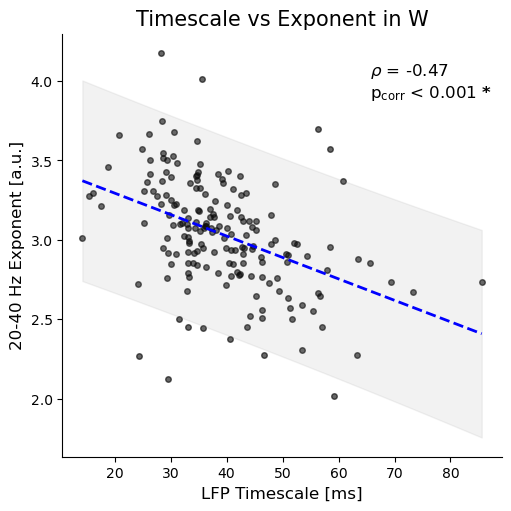

N3
Generating 1000 permutations...


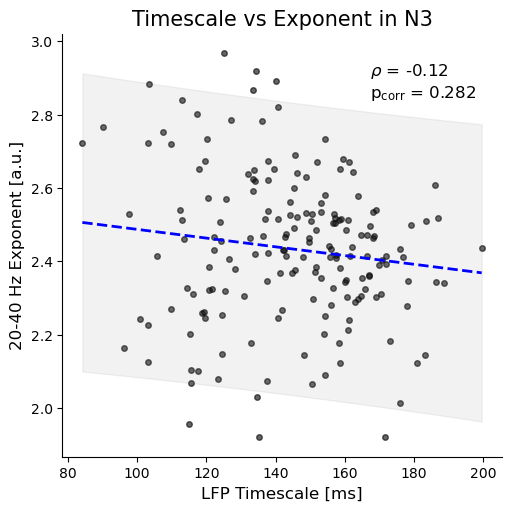

R
Generating 1000 permutations...


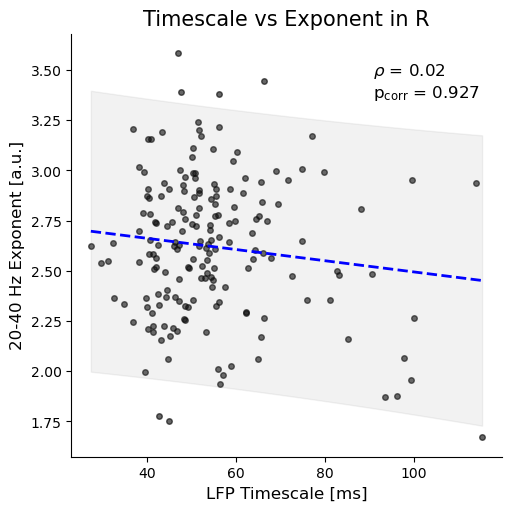

In [16]:
for stage in ["W", "N3", "R"]:

    print(stage)
    fig, ax = plt.subplots(1, 1, figsize=(5, 5), layout="constrained")
    x = df_tau_lfp[stage].loc[df_exp[stage].index].to_numpy().squeeze()
    y = df_exp[stage].to_numpy().squeeze()
    rho, p_corr = uti.get_pcorr(x, y, map_coords, method="vasa", corr_type="spearman")
    ax = plot_corr(
        ax,
        x,
        y,
        rho,
        p_corr,
        color_line="b",
        title=f"Timescale vs Exponent in {stage}",
        xlabel="LFP Timescale [ms]",
        ylabel="20-40 Hz Exponent [a.u.]",
    )

    plt.show()